In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

path_to_export = os.path.join("..", "app", "export", "telemetry_Hugo_PDVN_20250811_231630.csv") # PATH TO THE EXPORT FILE YOU WANT TO ANALYZE

df = pd.read_csv(path_to_export)
df.head()

,timestamp,session,session_name,gear,brake_percent,throttle_percent,driver_name,vehicle_name,place
0,2025-08-11T20:03:43.464Z,5,Qualifying_1,0,100.0,0.0,Hugo PDVN,Manthey 2025 #90:LM,6
1,2025-08-11T20:03:43.570Z,5,Qualifying_1,0,100.0,0.0,Hugo PDVN,Manthey 2025 #90:LM,6
2,2025-08-11T20:03:43.678Z,5,Qualifying_1,0,100.0,0.0,Hugo PDVN,Manthey 2025 #90:LM,8
3,2025-08-11T20:03:43.785Z,5,Qualifying_1,0,100.0,0.0,Hugo PDVN,Manthey 2025 #90:LM,8
4,2025-08-11T20:03:43.890Z,5,Qualifying_1,0,100.0,0.0,Hugo PDVN,Manthey 2025 #90:LM,8


In [2]:
df_qualifying = df[df['session_name'] == 'Qualifying_1']
df_qualifying['session_name'].value_counts()


session_name
Qualifying_1    8465
Name: count, dtype: int64

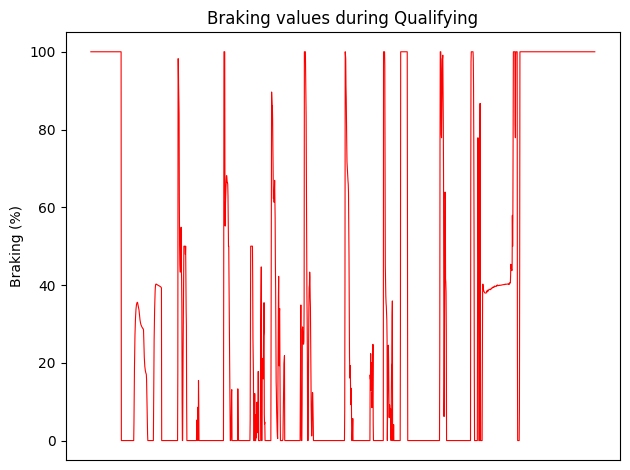

In [11]:
sample_df = df_qualifying[:2000]
plt.plot(sample_df['timestamp'], sample_df['brake_percent'], linewidth=0.8, color='red')
plt.title('Braking values during Qualifying')
plt.xlabel('Time')
plt.ylabel('Braking (%)')
plt.gca().get_xaxis().set_visible(False)


plt.tight_layout()
plt.show()

Nombre de segments de freinage trouvés: 14
Segment 1: 20 points, max freinage: 98.2%
Segment 2: 18 points, max freinage: 50.0%
Segment 3: 28 points, max freinage: 100.0%
Segment 4: 16 points, max freinage: 50.0%
Segment 5: 39 points, max freinage: 89.7%
Segment 6: 24 points, max freinage: 100.0%
Segment 7: 30 points, max freinage: 100.0%
Segment 8: 17 points, max freinage: 100.0%
Segment 9: 31 points, max freinage: 100.0%
Segment 10: 29 points, max freinage: 100.0%
Segment 11: 17 points, max freinage: 100.0%
Segment 12: 7 points, max freinage: 77.9%
Segment 13: 5 points, max freinage: 86.7%
Segment 14: 142 points, max freinage: 100.0%


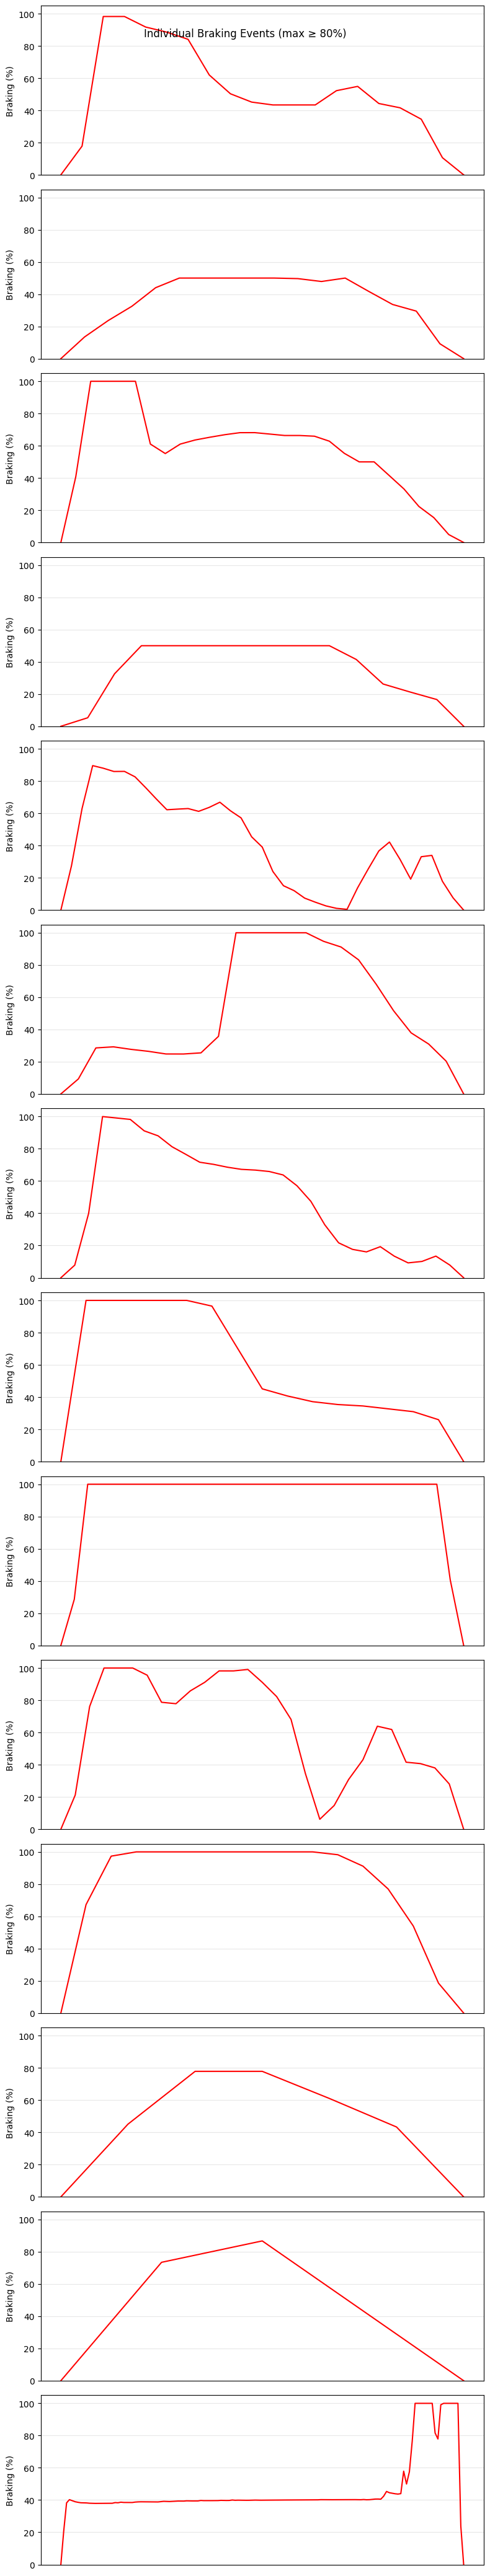

In [21]:
# Fonction corrigée pour identifier les vrais segments de freinage
def find_braking_segments(df, min_brake_intensity=50):
    """
    Trouve les segments de freinage qui commencent et finissent par 0
    Ne prend que le dernier 0 avant le freinage pour éviter les longues séries de zéros
    """
    braking_segments = []
    
    # Reset index pour avoir un index continu
    df_reset = df.reset_index(drop=True)
    
    i = 0
    while i < len(df_reset) - 1:
        # Chercher une transition de 0 vers >0 (début de freinage)
        if (df_reset.loc[i, 'brake_percent'] == 0 and 
            df_reset.loc[i + 1, 'brake_percent'] > 0):
            
            start_idx = i  # Le dernier 0 avant le freinage
            
            # Chercher la fin du freinage (retour à 0)
            end_idx = None
            max_brake = 0
            
            for k in range(i + 1, len(df_reset)):
                current_brake = df_reset.loc[k, 'brake_percent']
                max_brake = max(max_brake, current_brake)
                
                # Fin du freinage : transition de >0 vers 0
                if current_brake == 0:
                    end_idx = k  # On inclut le 0 de fin
                    break
            
            # Si on a trouvé un segment complet avec assez d'intensité
            if end_idx is not None and max_brake >= min_brake_intensity:
                segment = df_reset.loc[start_idx:end_idx].copy()
                braking_segments.append(segment)
                i = end_idx  # Continuer après ce segment
            else:
                i += 1
        else:
            i += 1
    
    return braking_segments

# Identifier les segments de freinage corrects
braking_segments = find_braking_segments(sample_df, min_brake_intensity=50)

print(f"Nombre de segments de freinage trouvés: {len(braking_segments)}")
for i, segment in enumerate(braking_segments):
    print(f"Segment {i+1}: {len(segment)} points, max freinage: {segment['brake_percent'].max():.1f}%")

# Création des subplots
fig, axes = plt.subplots(len(braking_segments), 1, figsize=(8, 3*len(braking_segments)))

# S'il n'y a qu'un seul subplot, on force en liste
if len(braking_segments) == 1:
    axes = [axes]

for ax, seg in zip(axes, braking_segments):
    ax.plot(seg['timestamp'], seg['brake_percent'], color='red')
    ax.set_ylim(0, 105)
    ax.set_ylabel('Braking (%)')
    ax.grid(True, alpha=0.3)
    ax.get_xaxis().set_visible(False)

fig.suptitle('Individual Braking Events (max ≥ 80%)')
plt.tight_layout()
plt.show()